# Calculate Prime Numbers and Plot Them

Script calculating all prime numbers up to 100000 and plots them in a histogram, effectively counting the number of primes in intervals of 1000. This illustration/test program is related to the [Prime Number Theorem](https://en.wikipedia.org/wiki/Prime_number_theorem).


### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 09-11-2024 (latest update)

In [1]:
import numpy as np               
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy import stats

# Display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

iminuit version: 2.30.1


Decide whether or not the program should save the plot along with the maxmimum prime number and the starting point:

In [2]:
save_plots = True
Nmax = 100000              # Maximum prime number
N    = 2                   # Starting value

## Main program:


Calculating prime numbers comes down to taking a number (here `N`), and testing if it is prime by dividing it by all numbers up the the square root of it. If no number divides `N` (tested using the `%` operator, which returns the remainder: `6%3 = 0`, `5%2 = 1`, etc.), then `N` is prime!
***
See if you can follow this in python program form below. There are only 9 lines in total! The central part consists of a While-loop, which loops as long as the statement is true. It is true to begin with (`N=2`, `Nmax = 100000`), but at some point `N` will have increased enough to equal `Nmax`, and the looping stops.
***
We start by creating empty list for primes. We dont create a numpy array since we don't know the size of it before creation:

In [3]:
primes = []

while (N < Nmax):
    # print("Potential Prime number I want to test: ", N)
    hit = False                # Define a variable "hit", with starting value "False".

    for i in range (2, int(np.sqrt(N)) + 1) :   # Loop over the possible divisors.
        # print("  I'm testing the first number with the second and get the third: ", N, i, N%i)

        if N%i == 0:           # If the remainder of the integer division is 0
            hit = True         # hit = "True" (i.e. the number being tested had a divisor, and is not a prime)
            break              # Skip the rest of the possible divisors.

    if not hit:             # If no number gave a perfect integer division (i.e. with remainder 0)...
        primes.append(N)
        if (N < 50) :
            print("I got a prime", N)   # ...the it is a prime number.

    N += 1                     # Increase N by one (this can be done smarter/faster).

I got a prime 2
I got a prime 3
I got a prime 5
I got a prime 7
I got a prime 11
I got a prime 13
I got a prime 17
I got a prime 19
I got a prime 23
I got a prime 29
I got a prime 31
I got a prime 37
I got a prime 41
I got a prime 43
I got a prime 47


We can now convert the Python list into a Numpy array:

In [4]:
primes = np.array(primes)
print("First 10 primes, ", primes[:10])

First 10 primes,  [ 2  3  5  7 11 13 17 19 23 29]


## Draw output:
Having computed the prime numbers, we now try to plot the distribution of them to see if there are any interesting patterns. 

We first define the number of bins and the minimum/maximum x value:

In [5]:
Nbins = 100
xmin = 0
xmax = Nmax
binwidth = int((xmax-xmin)/Nbins)

## Note on histograms and binning (IMPORTANT!):
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few seconds of consideration from the beginning. Some words of advice are:<br>
1) Choose a range that contains the (relevant) data with round numbers (e.g. 40-100, not 47-98).<br>
   Omit (or make an overflow bin of) long tails, if they are not relevant.<br>
2) Choose a number of bins, which gives a "round" bin width,
   e.g. with a range 40-100, choose 60 bins (bin width = 1.0) instead of 50 (bin width = 1.2).<br>
3) If the input is integer (or otherwise discrete), choose the binning accordingly,
   and put values in the middle of the bin.<br> E.g. a histogram for dice outcome would be the range 0.5-6.5 with 6 bins.<br>
4) There are many ways to calculate a reasonable number of bins.
   A rough rule of thumb is to have $\sqrt{N}$ bins, given $N$ entries in a histogram.<br>

In this case we want the distribution of prime numbers as a plot with error bars and not "just" a regular histogram.  
Therefore we don't do `ax.hist(primes, bins=Nbins, ...)`, but rather bin it using Numpy:

In [6]:
y, bin_edges = np.histogram(primes, bins=Nbins, range=(xmin, xmax))
x = bin_edges[:-1] + 0.5*np.diff(bin_edges)       # Calculate the x-values as the center of the bins.
sy = np.sqrt(y)                                   # Assume Poissonian errors (more on that later!)

Given values of x, y, and uncertainties on y, we plot the data:

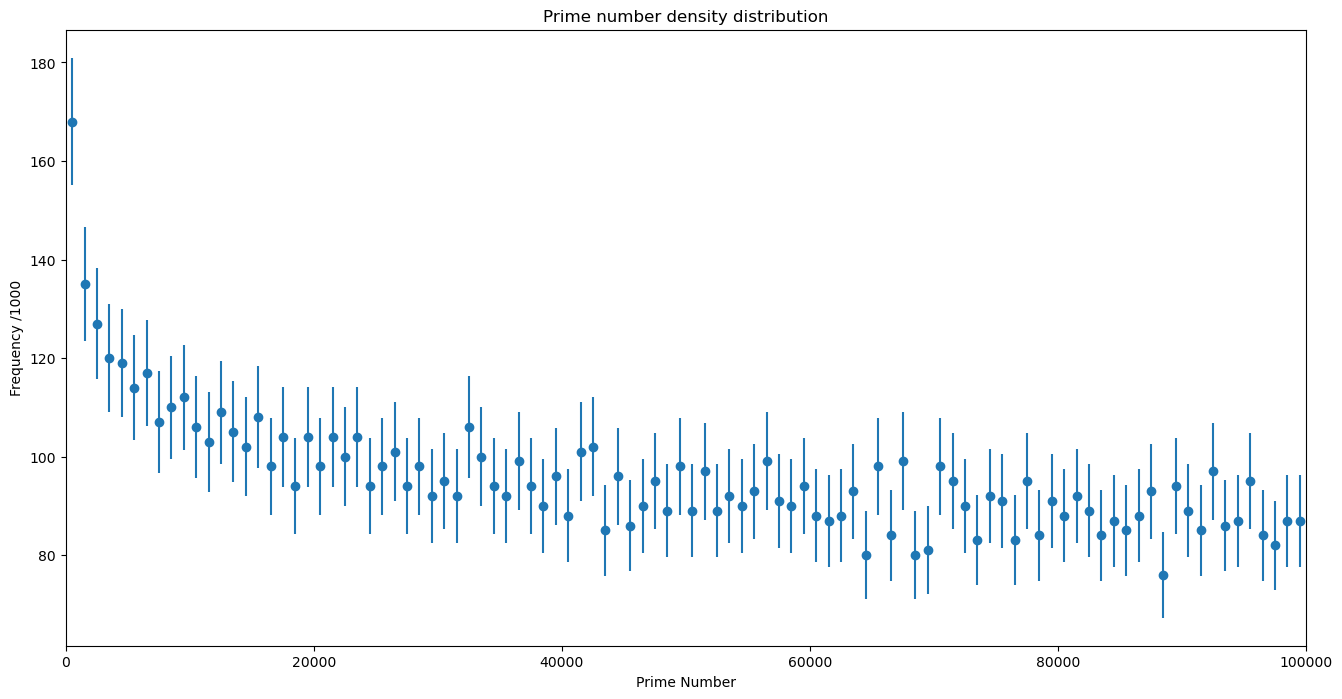

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, y, sy, fmt='o', label='Prime number distribution')
ax.set(xlim=(xmin, xmax), 
       xlabel="Prime Number", 
       ylabel=f"Frequency /{binwidth:4d}",    # To put the bin width in the y-axis label
       title="Prime number density distribution");

## Fitting the data:

The __[Prime Number Theorem](http://en.wikipedia.org/wiki/Prime_number_theorem)__ states, that the number of prime numbers follows roughly the function $f(x) = \frac{1}{\ln(x)}$. We have binned our prime numbers, so we must have a function with a few more degrees of freedom: $f(x) = c_0 + \frac{c_1}{\ln(x)}$, where $c_0$ and $c_1$ are constants that needs to be fitted ($c_0$ should be around zero).

We define the function to fit:

In [8]:
def fit_prime(x, c0, c1) :
    return c0 + c1 / np.log(x)

Make a chi2-regression (called "LeastSquares" in Minuit) object based on the fit function `fit_prime` and the `x`, `y` and `sy` values: 

In [9]:
least_squares = LeastSquares(x, y, sy, fit_prime)     # Defines the ChiSquare fit
mfit = Minuit(least_squares, c0=0, c1=0)              # Defines the Minuit object "mfit" and starting values for c0 and c1
mfit.migrad()  # Finds minimum of least_squares function (i.e. fits!)
mfit.hesse()   # Accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.85 (χ²/ndof = 0.2)      │              Nfcn = 47               │
│ EDM = 4.09e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ c0   │    -2     │     9     │            │            │         │         │       │
│ 1 │ c1   │  1.01e3   │  0.10e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       c0       c1 │
├────┼───────────────────┤
│ c0 │     88.9     -930 │
│ c1 │     -930 9.73e+03 │
└────┴───────────────────┘

Extract the fit parameters:

In [10]:
c0, c1 = mfit.values[:]               # Get the output arguments
for name in mfit.parameters:          # Print the output (parameters of the fit)
    print(f"Fit value: {name} = {mfit.values[name]:.1f} +/- {mfit.errors[name]:.1f}")

Fit value: c0 = -1.7 +/- 9.4
Fit value: c1 = 1012.6 +/- 98.6


And plot the fit along with some extra text to the plot:

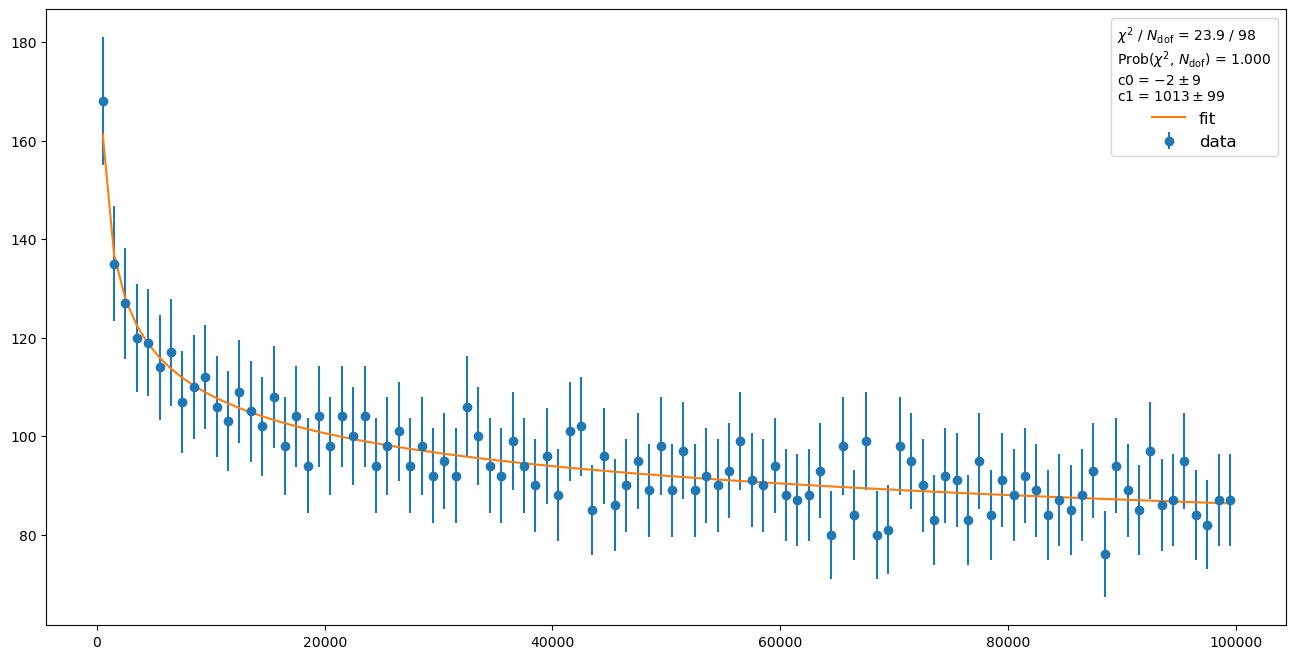

In [11]:
# Draw data and fitted line:
fig2, ax2 = plt.subplots(figsize=(16, 8))
ax2.errorbar(x, y, sy, fmt="o", label="data")
ax2.plot(x, fit_prime(x, *mfit.values), label="fit")

# Display legend with fitting information:
chi2 = mfit.fval                     # ChiSquare value
Ndof = len(x[y > 0]) - mfit.nfit     # Number of (non-empty) bins
Prob = stats.chi2.sf(chi2, Ndof)     # ChiSquare probability given Ndof

#fit_info = [f"Prob($\\chi^2$={chi2:.1f} / $N_\\mathrm{{dof}} = {Ndof}$) = {Prob:.3f}",]
#fit_info = [f"$\\chi^2$ =      {chi2:.1f}", f"$N_\\mathrm{{dof}}$ =       {Ndof}", f"Prob = {Prob:.3f}",]
fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit.parameters, mfit.values[:], mfit.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))
    fit_info.append(f"{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$")
plt.legend(title="\n".join(fit_info), fontsize=12);

Finally we save the plots if save_plots is True:

In [12]:
if save_plots:
    fig2.savefig('PrimeNumberDistribution.pdf', dpi=600)

### Note of concern:
You may notice, that the ChiSquare value is way below the number of degrees of freedom, indicating - as the data points also show - that the fit is "way too good". The data simply doesn't jump around as much as the uncertainties indicate. One should expect about 1/3 (well 32%) of the data points being more than one unit of uncertainty away, but this is far from the case. So what is the problem? Where did we go wrong?<br>
Hint: Prime number mutual independence!

***

### Note on converting between .py and .ipynb:

In case you want to export the notebook to a normal python file (.py), you can uncomment the command below (but keep the "`!`") and run the cell. This exports the notebook to a Python file.

In [13]:
# !jupyter nbconvert --to script CalcAndPlotPrimeNumbers_original.ipynb

(In the case that you want to convert back from .py to Notebook.ipynb file, run the following command:
`jupyter nbconvert --to notebook IntroToPlottingAndFitting.py` in a terminal. In case you want to do it automatically in the Python script, add the line `os.system("jupyter nbconvert --to notebook IntroToPlottingAndFitting.py")`